## Stock Price Prediction with Sentiment Analysis

In [1]:
# %%time
# !pip install charset-normalizer pandas_ta yfinance statsmodels tqdm scikit-learn tensorflow

In [2]:
%%time
# To reload the imported modules automatically
%load_ext autoreload
%autoreload 2

CPU times: user 3.72 ms, sys: 3.51 ms, total: 7.23 ms
Wall time: 6.57 ms


In [3]:
%%time
# Import the necessary libraries and modules
import os
import warnings
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from statsmodels.tsa.stattools import adfuller

# Import modules
import config as cfg
import data_processing as dp
import sentiment_analysis as sa
import model as mdl
import utils as ut
import time
import keras_tuner as kt
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


CPU times: user 5.2 s, sys: 854 ms, total: 6.05 s
Wall time: 7.17 s


In [4]:
%%time
start_time = time.time()
warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.makedirs(cfg.DATASET_DIR, exist_ok=True)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/sandy/PycharmProjects/stock_market_analysis
CPU times: user 208 µs, sys: 144 µs, total: 352 µs
Wall time: 300 µs


In [5]:
%%time
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Set memory growth to be the same for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.list_logical_devices("GPU")
        print(
            f"✅ {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs configured with memory growth."
        )

    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(f"Error setting memory growth: {e}")
else:
    print("🤷 No GPU detected. TensorFlow will run on CPU.")

✅ 1 Physical GPUs, 1 Logical GPUs configured with memory growth.
CPU times: user 1.37 ms, sys: 1.2 ms, total: 2.57 ms
Wall time: 2.12 ms


I0000 00:00:1753816605.712412  858888 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753816605.712437  858888 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Load and Analyze News Data

In [6]:
%%time
sentiment_csv_path = f"{cfg.DATASET_DIR}/{cfg.STOCK_SYMBOL}_daily_sentiment.csv"

if cfg.UPDATE_SENTIMENT_CSV or not os.path.exists(sentiment_csv_path):
    print("Generating new sentiment data and saving to CSV...")
    news_df = dp.load_and_analyze_news_data(cfg.NEWS_DATA_FILE, cfg.STOCK_SYMBOL)
    company_sentiment_df = sa.process_news_sentiment(news_df, cfg.STOCK_SYMBOL)
    daily_sentiment_df = sa.aggregate_daily_sentiment(company_sentiment_df)
    ut.save_dataframe(daily_sentiment_df, sentiment_csv_path)
else:
    print(f"Loading existing sentiment data from {sentiment_csv_path}...")
    daily_sentiment_df = pd.read_csv(
        sentiment_csv_path, index_col="Date", parse_dates=True
    )

print("Sentiment data ready.")

Generating new sentiment data and saving to CSV...
Loading and selecting news data...
File path: Dataset/news_data.csv
Loaded 1400469 articles from Dataset/news_data.csv
🎯 Selected target stock: NVDA (3133 articles)
\n📰 Processing news sentiment for NVDA...
Initializing sentiment analyzer with model: ProsusAI/finbert
Using device: cpu
Analyzer initialized successfully.
Analyzing 3133 headlines in batches of 32...


  0%|          | 0/98 [00:00<?, ?it/s]

\nSentiment distribution:\n Sentiment
neutral     1573
positive     887
negative     673
Name: count, dtype: int64

📊 Aggregating daily sentiment scores...
DataFrame saved to Dataset/NVDA_daily_sentiment.csv
Sentiment data ready.
CPU times: user 1min 8s, sys: 11.2 s, total: 1min 20s
Wall time: 33.5 s


### Fetch Stock Data and Calculate Technical Indicators

In [7]:
%%time
START_DATE, END_DATE = ut.calculate_dynamic_date_range(daily_sentiment_df)

stock_filename = f"{cfg.STOCK_SYMBOL}_stock_data_{START_DATE}_to_{END_DATE}.csv"
stock_csv_path = os.path.join(cfg.DATASET_DIR, stock_filename)

if cfg.UPDATE_STOCK_CSV or not os.path.exists(stock_csv_path):
    print(f"Fetching new stock data from yfinance ({START_DATE} to {END_DATE})...")
    stock_data = dp.fetch_stock_data(cfg.STOCK_SYMBOL, START_DATE, END_DATE)
    if stock_data is not None:
        stock_data.to_csv(stock_csv_path)
        print(f"Stock data saved to {stock_csv_path}")
else:
    print(f"Loading existing stock data from {stock_csv_path}...")
    stock_data = pd.read_csv(stock_csv_path, index_col="Date", parse_dates=True)

# Calculate technical indicators from the loaded/fetched data
tech_data = dp.calculate_technical_indicators(stock_data)
print("Technical indicators calculated.")

Fetching new stock data from yfinance (2010-03-03 to 2020-06-10)...
\n📈 Fetching stock data for NVDA...
Successfully fetched 2586 days of data.
Stock data saved to Dataset/NVDA_stock_data_2010-03-03_to_2020-06-10.csv
Technical indicators calculated.
CPU times: user 77 ms, sys: 26.5 ms, total: 104 ms
Wall time: 537 ms


In [8]:
print("--- Checking for Stationarity of the 'Close' Price ---")

adf_result = adfuller(tech_data['Close'])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

if adf_result[1] > 0.05:
    print("Result: The 'Close' price series is likely non-stationary (p-value > 0.05)")
else:
    print("Result: The 'Close' price series is likely stationary (p-value <= 0.05)")

--- Checking for Stationarity of the 'Close' Price ---
ADF Statistic: 1.14666865386736
p-value: 0.9955958841793662
Result: The 'Close' price series is likely non-stationary (p-value > 0.05)


In [9]:
# Calculate daily returns, which will be our new target variable
print("--- Calculating Daily Returns ---")
tech_data['Returns'] = tech_data['Close'].pct_change()
tech_data = tech_data.dropna() # Drop the first row which will have a NaN return
print("'Returns' column created.")

enhanced_full_data = dp.create_enhanced_dataset(tech_data, daily_sentiment_df)
# Recalculate returns for the enhanced dataset as well
if enhanced_full_data is not None:
    enhanced_full_data['Returns'] = enhanced_full_data['Close'].pct_change()
    enhanced_full_data = enhanced_full_data.dropna()

--- Calculating Daily Returns ---
'Returns' column created.

🔗 Merging sentiment and technical data...
Enhanced dataset shape: (2386, 38)


### Prepare Data for LSTM & SVM Models

In [10]:
%%time
# Prepare data for models using only technical indicators
X_train_tech, X_test_tech, y_train_tech, y_test_tech, scaler_tech = (
    mdl.prepare_data_for_lstm(
        tech_data,
        cfg.BASELINE_FEATURES,
        cfg.BASELINE_TARGET,
        cfg.SEQUENCE_LENGTH,
        cfg.TEST_SIZE,
    )
)

# Prepare data for models using sentiment + technical indicators
enhanced_full_data = dp.create_enhanced_dataset(tech_data, daily_sentiment_df)
X_train_enh, X_test_enh, y_train_enh, y_test_enh, scaler_enh = (
    mdl.prepare_data_for_lstm(
        enhanced_full_data,
        cfg.ENHANCED_FEATURES,
        cfg.ENHANCED_TARGET,
        cfg.SEQUENCE_LENGTH,
        cfg.TEST_SIZE,
    )
)


🔗 Merging sentiment and technical data...
Enhanced dataset shape: (2386, 38)
CPU times: user 8.47 ms, sys: 3.4 ms, total: 11.9 ms
Wall time: 11.3 ms


### Single Layer LSTM Models

In [11]:
%%time
print("\n--- Tuning Single-Layer LSTM Model ---")

# Define the input shape from your training data
input_shape = (X_train_tech.shape[1], X_train_tech.shape[2])

# Instantiate the tuner, passing the input_shape to the model builder
tuner_single_lstm = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_single_layer_lstm(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="single_layer_lstm",
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search
print("Starting hyperparameter search...")
tuner_single_lstm.search(
    X_train_tech,
    y_train_tech,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_single_lstm = tuner_single_lstm.get_best_hyperparameters(num_trials=1)[0]
single_lstm_model = tuner_single_lstm.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Single-Layer LSTM:
Units: {best_hps_single_lstm.get('units')}
Dropout: {best_hps_single_lstm.get('dropout'):.2f}
Learning Rate: {best_hps_single_lstm.get('learning_rate')}
---
"""
)

Trial 30 Complete [00h 00m 14s]
val_loss: 0.003671130398288369

Best val_loss So Far: 0.0036559191066771746
Total elapsed time: 00h 03m 12s

Hyperparameter search complete.

---
Optimal Hyperparameters for Single-Layer LSTM:
Units: 160
Dropout: 0.20
Learning Rate: 0.01
---

CPU times: user 2min 35s, sys: 1min 2s, total: 3min 37s
Wall time: 3min 13s



--- Evaluating Best Single-Layer LSTM Model ---
{'Model': 'Single-Layer LSTM', 'RMSE': np.float64(0.035704756991456914), 'MAE': 0.024112047601540718, 'MAPE (%)': np.float64(55697.83320474954), 'R-squared': -0.025712416866839227, 'Directional_Accuracy': np.float64(68.0672268907563), 'MASE': np.float64(0.47166301286108614)}
Plot saved to Output/NVDA_Single-Layer_LSTM_analysis.png


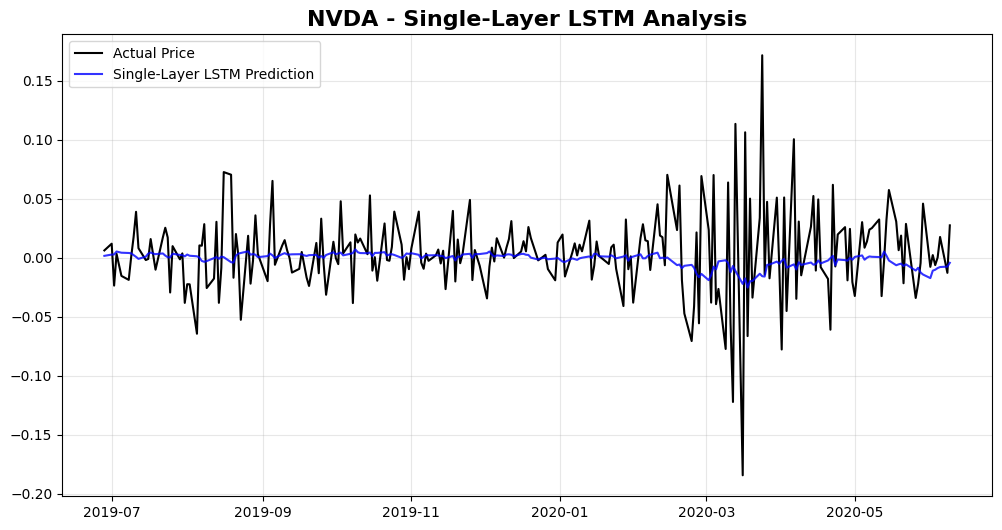

CPU times: user 337 ms, sys: 32.6 ms, total: 370 ms
Wall time: 389 ms


In [12]:
%%time
# --- Evaluation using the best model ---
print("\n--- Evaluating Best Single-Layer LSTM Model ---")
single_layer_lstm_preds = single_lstm_model.predict(X_test_tech, verbose=0)

# Re-create the scaler based on the training data's 'Returns' price
close_scaler = MinMaxScaler()
close_scaler.fit(tech_data[["Returns"]][: len(X_train_tech)])  # Fit only on the training part

# Inverse transforms the actual and predicted values
y_test_tech_scaled = close_scaler.inverse_transform(y_test_tech.reshape(-1, 1))
base_preds_scaled = close_scaler.inverse_transform(single_layer_lstm_preds)

# Calculate and print metrics
baseline_metrics = ut.calculate_metrics(
    y_test_tech_scaled, base_preds_scaled, "Single-Layer LSTM", y_train_tech
)
print(baseline_metrics)

# Plot the results
test_dates_tech = tech_data.index[-len(y_test_tech_scaled) :]
ut.plot_non_keras_results(
    y_test_tech_scaled,
    base_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Single-Layer LSTM",
)

### Multi Layer LSTM Models

In [13]:
%%time
print("\n--- Tuning Multi-Layer LSTM Model ---")

# Define the input shape from our training data
input_shape = (X_train_tech.shape[1], X_train_tech.shape[2])

# Instantiate the tuner
tuner_multi_lstm = kt.Hyperband(
    # Pass the input_shape to the model-building function
    hypermodel=lambda hp: mdl.build_multi_layer_lstm(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="multi_layer_lstm",  # New project name to store results separately
    overwrite=False,
)

# Define a callback to stop training early if val_loss isn't improving
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search
print("Starting hyperparameter search...")
tuner_multi_lstm.search(
    X_train_tech,
    y_train_tech,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_multi_lstm = tuner_multi_lstm.get_best_hyperparameters(num_trials=1)[0]
multi_layer_model = tuner_multi_lstm.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Multi-Layer LSTM:
Units Layer 1: {best_hps_multi_lstm.get('units_1')}
Units Layer 2: {best_hps_multi_lstm.get('units_2')}
Dropout: {best_hps_multi_lstm.get('dropout'):.2f}
Learning Rate: {best_hps_multi_lstm.get('learning_rate')}
---
"""
)

Trial 30 Complete [00h 00m 27s]
val_loss: 0.004890273790806532

Best val_loss So Far: 0.0036034404765814543
Total elapsed time: 00h 05m 23s

Hyperparameter search complete.

---
Optimal Hyperparameters for Multi-Layer LSTM:
Units Layer 1: 256
Units Layer 2: 96
Dropout: 0.30
Learning Rate: 0.01
---

CPU times: user 4min 36s, sys: 1min 37s, total: 6min 13s
Wall time: 5min 24s



--- Evaluating Best Multi-Layer LSTM Model ---
Plotting results for the best model...
Plot saved to Output/NVDA_Multi-Layer_LSTM_analysis.png


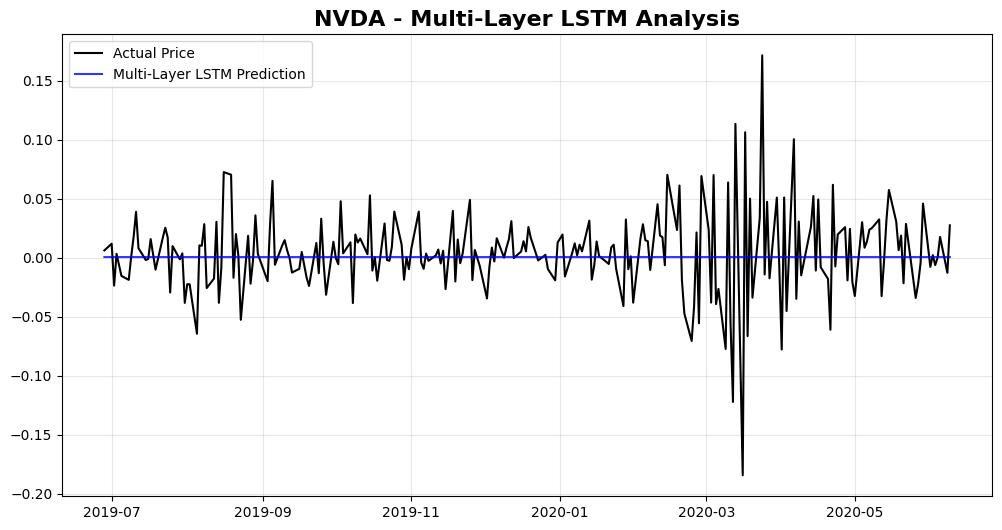

{'Model': 'Multi-Layer LSTM', 'RMSE': np.float64(0.03542701081906698), 'MAE': 0.024354118571036993, 'MAPE (%)': np.float64(20134.058068727623), 'R-squared': -0.009816516405051878, 'Directional_Accuracy': np.float64(75.21008403361344), 'MASE': np.float64(0.4763982358784595)}
CPU times: user 541 ms, sys: 70.5 ms, total: 611 ms
Wall time: 647 ms


In [14]:
%%time
# Proceed with evaluation using the best model
print("\n--- Evaluating Best Multi-Layer LSTM Model ---")
multi_preds = multi_layer_model.predict(X_test_tech, verbose=0)

# We can reuse the same scaler fitted before
y_test_tech_scaled = close_scaler.inverse_transform(y_test_tech.reshape(-1, 1))
multi_preds_scaled = close_scaler.inverse_transform(multi_preds)

multi_layer_metrics = ut.calculate_metrics(
    y_test_tech_scaled, multi_preds_scaled, "Multi-Layer LSTM", y_train_tech
)
test_dates_tech = tech_data.index[-len(y_test_tech_scaled) :]

# Plot the results
print("Plotting results for the best model...")
ut.plot_non_keras_results(
    y_test_tech_scaled,
    multi_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Multi-Layer LSTM",
)

print(multi_layer_metrics)

### Single-Layer Enhanced LSTM Model

In [15]:
%%time
print("\n--- Tuning Single-Layer Enhanced LSTM Model ---")

# Define the input shape from our ENHANCED training data
input_shape = (X_train_enh.shape[1], X_train_enh.shape[2])

# Instantiate the tuner
tuner_enh_single_lstm = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_single_layer_lstm(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="enhanced_single_layer_lstm",
    overwrite=False,
)

# Define a callback for early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the ENHANCED data
print("Starting hyperparameter search on enhanced data...")
tuner_enh_single_lstm.search(
    X_train_enh,
    y_train_enh,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_enh_single = tuner_enh_single_lstm.get_best_hyperparameters(num_trials=1)[0]
enhanced_model = tuner_enh_single_lstm.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Enhanced Single-Layer LSTM:
Units: {best_hps_enh_single.get('units')}
Dropout: {best_hps_enh_single.get('dropout'):.2f}
Learning Rate: {best_hps_enh_single.get('learning_rate')}
---
"""
)

Trial 30 Complete [00h 00m 15s]
val_loss: 0.0040361168794333935

Best val_loss So Far: 0.003610982559621334
Total elapsed time: 00h 03m 58s
\nHyperparameter search complete.

---
Optimal Hyperparameters for Enhanced Single-Layer LSTM:
Units: 192
Dropout: 0.50
Learning Rate: 0.01
---

CPU times: user 3min 15s, sys: 1min 12s, total: 4min 28s
Wall time: 3min 58s



--- Evaluating Best Enhanced Single-Layer LSTM Model ---
Plotting results for the best enhanced model...
Plot saved to Output/NVDA_Enhanced_LSTM_analysis.png


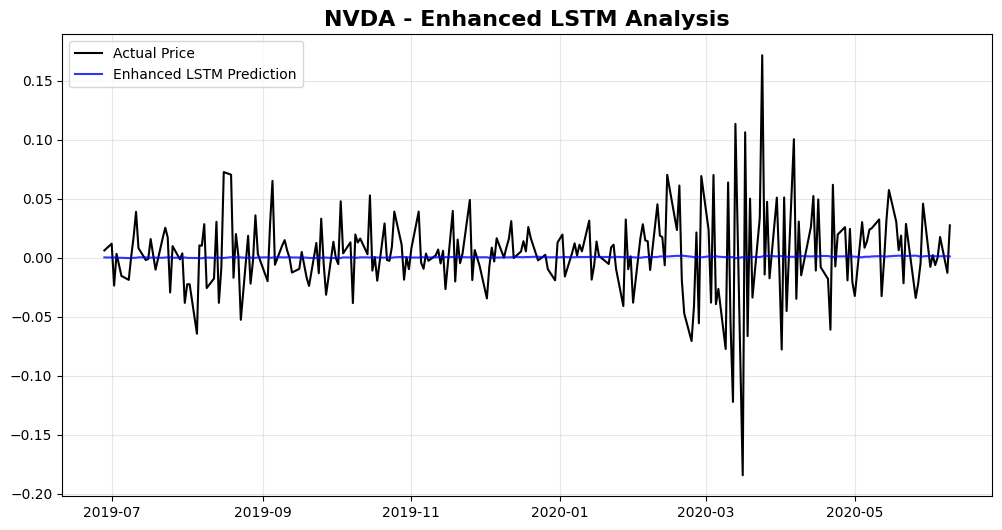

{'Model': 'Enhanced LSTM', 'RMSE': np.float64(0.03547219192189835), 'MAE': 0.024430661942136913, 'MAPE (%)': np.float64(7502.357659624439), 'R-squared': -0.012393855899492934, 'Directional_Accuracy': np.float64(26.05042016806723), 'MASE': np.float64(0.47789552377470707)}
CPU times: user 377 ms, sys: 41.3 ms, total: 418 ms
Wall time: 429 ms


In [16]:
%%time
print("\n--- Evaluating Best Enhanced Single-Layer LSTM Model ---")
enh_preds = enhanced_model.predict(X_test_enh, verbose=0)

# IMPORTANT: Use the scaler that was fitted to the enhanced data
close_scaler_enh = MinMaxScaler().fit(enhanced_full_data[["Returns"]][: len(X_train_enh)])

y_test_enh_scaled = close_scaler_enh.inverse_transform(y_test_enh.reshape(-1, 1))
enh_preds_scaled = close_scaler_enh.inverse_transform(enh_preds)

enhanced_metrics = ut.calculate_metrics(
    y_test_enh_scaled, enh_preds_scaled, "Enhanced LSTM", y_train_enh
)
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled):]

# Plot the results
print("Plotting results for the best enhanced model...")
ut.plot_non_keras_results(
    y_test_enh_scaled,
    enh_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Enhanced LSTM",
)

print(enhanced_metrics)

### Multi-Layer Enhanced LSTM Model

In [17]:
%%time
print("\n--- Tuning Multi-Layer Enhanced LSTM Model ---")

# Define the input shape from our ENHANCED training data
input_shape = (X_train_enh.shape[1], X_train_enh.shape[2])

# Instantiate the tuner
tuner_enh_multi_lstm = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_multi_layer_lstm(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="enhanced_multi_layer_lstm",
    overwrite=False,
)

# Define a callback for early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the ENHANCED data
print("Starting hyperparameter search on enhanced data...")
tuner_enh_multi_lstm.search(
    X_train_enh,
    y_train_enh,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_enh_multi = tuner_enh_multi_lstm.get_best_hyperparameters(num_trials=1)[0]
multi_enhanced_model = tuner_enh_multi_lstm.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Multi-Layer Enhanced LSTM:
Units Layer 1: {best_hps_enh_multi.get('units_1')}
Units Layer 2: {best_hps_enh_multi.get('units_2')}
Dropout: {best_hps_enh_multi.get('dropout'):.2f}
Learning Rate: {best_hps_enh_multi.get('learning_rate')}
---
"""
)

Trial 30 Complete [00h 00m 20s]
val_loss: 0.0036943810991942883

Best val_loss So Far: 0.003602810436859727
Total elapsed time: 00h 06m 32s
\nHyperparameter search complete.

---
Optimal Hyperparameters for Multi-Layer Enhanced LSTM:
Units Layer 1: 192
Units Layer 2: 64
Dropout: 0.40
Learning Rate: 0.01
---

CPU times: user 5min 20s, sys: 1min 53s, total: 7min 14s
Wall time: 6min 33s



--- Evaluating Best Multi-Layer Enhanced LSTM Model ---
Plotting results for the best model...
Plot saved to Output/NVDA_Multi-Layer_Enhanced_LSTM_analysis.png


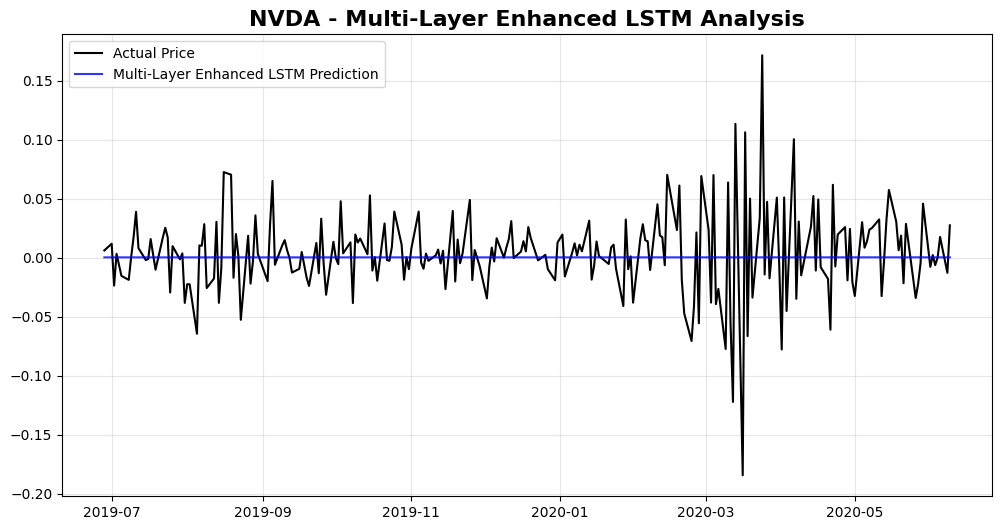

{'Model': 'Multi-Layer Enhanced LSTM', 'RMSE': np.float64(0.035450027817685185), 'MAE': 0.024377139748445735, 'MAPE (%)': np.float64(10276.862408387327), 'R-squared': -0.011129102215643671, 'Directional_Accuracy': np.float64(70.58823529411765), 'MASE': np.float64(0.4768485600514892)}
CPU times: user 689 ms, sys: 74.6 ms, total: 763 ms
Wall time: 788 ms


In [18]:
%%time
# Proceed with evaluation using the best ENHANCED model
print("\n--- Evaluating Best Multi-Layer Enhanced LSTM Model ---")
multi_enh_preds = multi_enhanced_model.predict(X_test_enh, verbose=0)

# We can reuse the same scaler fitted for the enhanced data
y_test_enh_scaled = close_scaler_enh.inverse_transform(y_test_enh.reshape(-1, 1))
multi_enh_preds_scaled = close_scaler_enh.inverse_transform(multi_enh_preds)

multi_enhanced_metrics = ut.calculate_metrics(
    y_test_enh_scaled, multi_enh_preds_scaled, "Multi-Layer Enhanced LSTM", y_train_enh
)
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled) :]

# Plot the results
print("Plotting results for the best model...")
ut.plot_non_keras_results(
    y_test_enh_scaled,
    multi_enh_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Multi-Layer Enhanced LSTM",
)

print(multi_enhanced_metrics)

### Support Vector Machine (SVM) Models

In [19]:
%%time
print("\n--- Preparing Data and Tuning SVM Model ---")
# SVM requires 2D input, so we flatten the sequence data
nsamples, nx, ny = X_train_tech.shape
X_train_svm_tech = X_train_tech.reshape((nsamples, nx * ny))

nsamples, nx, ny = X_test_tech.shape
X_test_svm_tech = X_test_tech.reshape((nsamples, nx * ny))

print(f"Reshaped baseline data for SVM: {X_train_svm_tech.shape}")


--- Preparing Data and Tuning SVM Model ---
Reshaped baseline data for SVM: (2117, 420)
CPU times: user 150 µs, sys: 69 µs, total: 219 µs
Wall time: 179 µs


Building and tuning SVM model with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ..........C=1, epsi

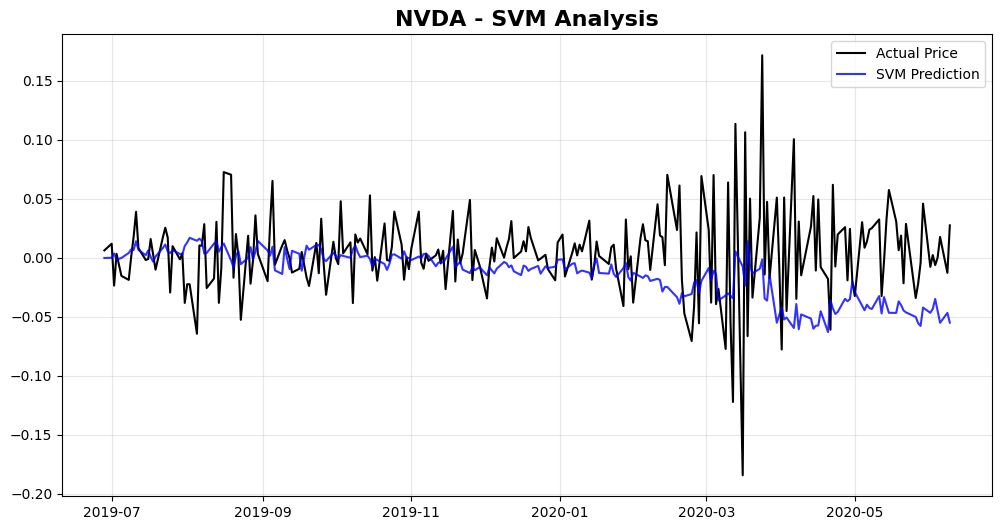

{'Model': 'SVM', 'RMSE': np.float64(0.04468544078213359), 'MAE': 0.03164824843551034, 'MAPE (%)': np.float64(154363.6930104539), 'R-squared': -0.6065917859516323, 'Directional_Accuracy': np.float64(54.621848739495796), 'MASE': np.float64(0.6190809032707423)}
CPU times: user 311 ms, sys: 891 ms, total: 1.2 s
Wall time: 5.95 s


In [20]:
%%time
# Build and train the SVM by running the grid search
baseline_svm_model = mdl.build_and_train_svm(X_train_svm_tech, y_train_tech)

# Evaluate the best model found by the tuner
print("\n--- Evaluating Best SVM Model ---")
base_svm_preds = baseline_svm_model.predict(X_test_svm_tech)

base_svm_preds_scaled = close_scaler.inverse_transform(base_svm_preds.reshape(-1, 1))
baseline_svm_metrics = ut.calculate_metrics(
    y_test_tech_scaled, base_svm_preds_scaled, "SVM", y_train_tech
)

# Plot the results
ut.plot_non_keras_results(
    y_test_tech_scaled,
    base_svm_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "SVM",
)

print(baseline_svm_metrics)

### Enhanced Support Vector Machine (SVM) Models

In [21]:
%%time
print("\n--- Preparing Enhanced Data and Tuning Enhanced SVM Model ---")
# Reshape the enhanced data for SVM's 2D input requirement
nsamples, nx, ny = X_train_enh.shape
X_train_svm_enh = X_train_enh.reshape((nsamples, nx * ny))

nsamples, nx, ny = X_test_enh.shape
X_test_svm_enh = X_test_enh.reshape((nsamples, nx * ny))

print(f"Reshaped enhanced data for SVM: {X_train_svm_enh.shape}")


--- Preparing Enhanced Data and Tuning Enhanced SVM Model ---
Reshaped enhanced data for SVM: (2117, 540)
CPU times: user 144 µs, sys: 177 µs, total: 321 µs
Wall time: 398 µs


Building and tuning SVM model with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.

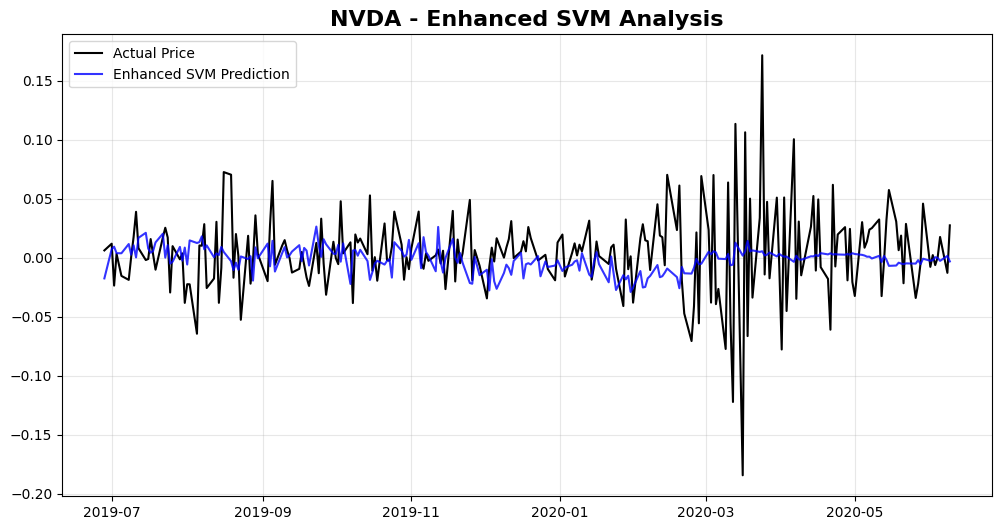

{'Model': 'Enhanced SVM', 'RMSE': np.float64(0.036999789618148655), 'MAE': 0.026738403002209296, 'MAPE (%)': np.float64(545088.1621687505), 'R-squared': -0.10146818921937006, 'Directional_Accuracy': np.float64(44.537815126050425), 'MASE': np.float64(0.5230379405152673)}
CPU times: user 364 ms, sys: 39.3 ms, total: 403 ms
Wall time: 1.73 s


In [22]:
%%time
# Build and train the enhanced SVM by running the grid search
enhanced_svm_model = mdl.build_and_train_svm(X_train_svm_enh, y_train_enh)

# Evaluate the best model found by the tuner
print("\n--- Evaluating Best Enhanced SVM Model ---")
enh_svm_preds = enhanced_svm_model.predict(X_test_svm_enh)

# Use the scaler fitted on the enhanced data to inverse the transformation
enh_svm_preds_scaled = close_scaler_enh.inverse_transform(enh_svm_preds.reshape(-1, 1))
enhanced_svm_metrics = ut.calculate_metrics(
    y_test_enh_scaled, enh_svm_preds_scaled, "Enhanced SVM", y_train_tech
)

# Plot the results
ut.plot_non_keras_results(
    y_test_enh_scaled,
    enh_svm_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Enhanced SVM",
)

print(enhanced_svm_metrics)

### GRU Model

In [23]:
%%time
print("\n--- Tuning Baseline GRU Model ---")

# Define the input shape from our baseline training data
input_shape = (X_train_tech.shape[1], X_train_tech.shape[2])

# Instantiate the tuner for the GRU model
tuner_base_gru = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_gru(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="baseline_gru",
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search
print("Starting GRU hyperparameter search...")
tuner_base_gru.search(
    X_train_tech,
    y_train_tech,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_base_gru = tuner_base_gru.get_best_hyperparameters(num_trials=1)[0]
baseline_gru_model = tuner_base_gru.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Baseline GRU:
Units Layer 1: {best_hps_base_gru.get('units_1')}
Units Layer 2: {best_hps_base_gru.get('units_2')}
Dropout: {best_hps_base_gru.get('dropout'):.2f}
Learning Rate: {best_hps_base_gru.get('learning_rate')}
---
"""
)

Trial 30 Complete [00h 00m 35s]
val_loss: 0.00406959792599082

Best val_loss So Far: 0.003582507837563753
Total elapsed time: 00h 06m 57s
\nHyperparameter search complete.

---
Optimal Hyperparameters for Baseline GRU:
Units Layer 1: 256
Units Layer 2: 32
Dropout: 0.30
Learning Rate: 0.01
---

CPU times: user 5min 46s, sys: 2min 5s, total: 7min 51s
Wall time: 6min 59s



--- Evaluating Best Baseline GRU Model ---
Plotting results for the best model...
Plot saved to Output/NVDA_Baseline_GRU_analysis.png


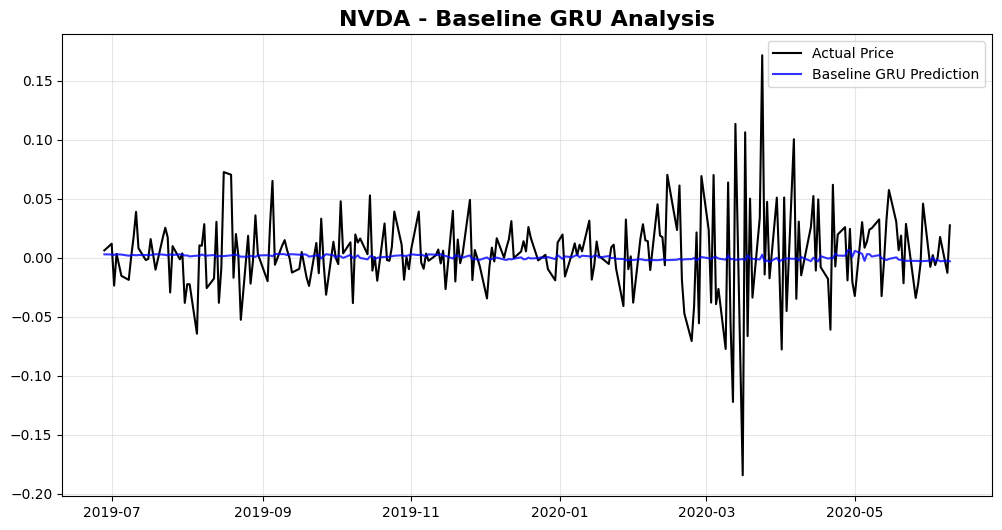

{'Model': 'Baseline GRU', 'RMSE': np.float64(0.035497501297494134), 'MAE': 0.024413647723035503, 'MAPE (%)': np.float64(66726.01106582677), 'R-squared': -0.013839055419137658, 'Directional_Accuracy': np.float64(42.857142857142854), 'MASE': np.float64(0.47756270351922875)}
CPU times: user 607 ms, sys: 108 ms, total: 716 ms
Wall time: 935 ms


In [24]:
%%time
# Proceed with evaluation using the best model
print("\n--- Evaluating Best Baseline GRU Model ---")
base_gru_preds = baseline_gru_model.predict(X_test_tech, verbose=0)

y_test_tech_scaled = close_scaler.inverse_transform(y_test_tech.reshape(-1, 1))
base_gru_preds_scaled = close_scaler.inverse_transform(base_gru_preds)

baseline_gru_metrics = ut.calculate_metrics(
    y_test_tech_scaled, base_gru_preds_scaled, "Baseline GRU", y_train_tech
)
test_dates_tech = tech_data.index[-len(y_test_tech_scaled) :]

# Plot the results
print("Plotting results for the best model...")
ut.plot_non_keras_results(
    y_test_tech_scaled,
    base_gru_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Baseline GRU",
)

print(baseline_gru_metrics)

### Enhanced GRU Model

In [25]:
%%time
print("\n--- Tuning Enhanced GRU Model ---")

# Define the input shape from our ENHANCED training data
input_shape = (X_train_enh.shape[1], X_train_enh.shape[2])

# Instantiate the tuner for the Enhanced GRU model
tuner_enh_gru = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_gru(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="enhanced_gru",  # New project name
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the enhanced data
print("Starting Enhanced GRU hyperparameter search...")
tuner_enh_gru.search(
    X_train_enh,
    y_train_enh,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_enh_gru = tuner_enh_gru.get_best_hyperparameters(num_trials=1)[0]
enhanced_gru_model = tuner_enh_gru.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Enhanced GRU:
Units Layer 1: {best_hps_enh_gru.get('units_1')}
Units Layer 2: {best_hps_enh_gru.get('units_2')}
Dropout: {best_hps_enh_gru.get('dropout'):.2f}
Learning Rate: {best_hps_enh_gru.get('learning_rate')}
---
"""
)

Trial 30 Complete [00h 00m 33s]
val_loss: 0.003997685853391886

Best val_loss So Far: 0.0035810419358313084
Total elapsed time: 00h 08m 11s
\nHyperparameter search complete.

---
Optimal Hyperparameters for Enhanced GRU:
Units Layer 1: 256
Units Layer 2: 96
Dropout: 0.40
Learning Rate: 0.01
---

CPU times: user 6min 42s, sys: 2min 27s, total: 9min 10s
Wall time: 8min 13s



--- Evaluating Best Enhanced GRU Model ---
Plotting results for the best model...
Plot saved to Output/NVDA_Enhanced_GRU_analysis.png


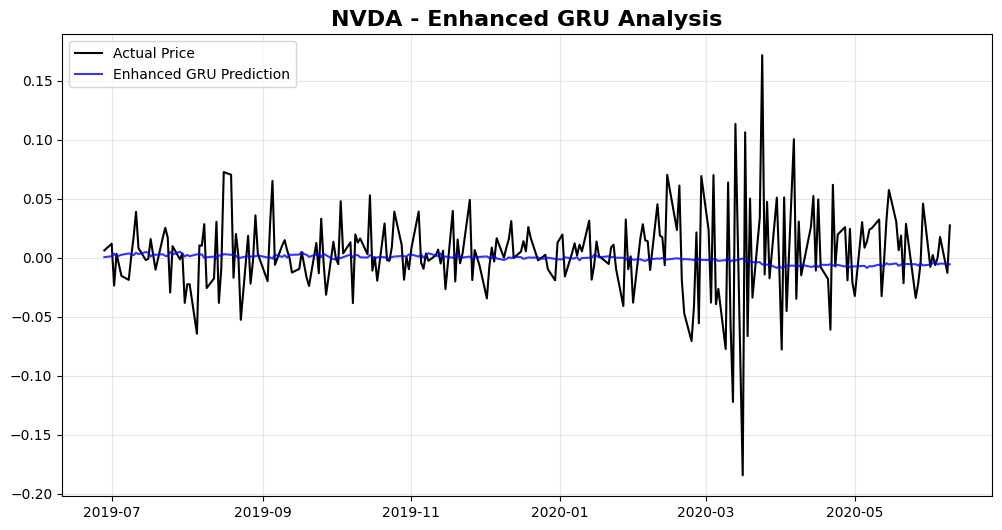

{'Model': 'Enhanced GRU', 'RMSE': np.float64(0.036093772728830485), 'MAE': 0.024785493829187447, 'MAPE (%)': np.float64(81112.03425916623), 'R-squared': -0.04818516433060416, 'Directional_Accuracy': np.float64(44.537815126050425), 'MASE': np.float64(0.4848364970039879)}
CPU times: user 876 ms, sys: 197 ms, total: 1.07 s
Wall time: 1.36 s


In [26]:
%%time
# Proceed with evaluation using the best model
print("\n--- Evaluating Best Enhanced GRU Model ---")
enh_gru_preds = enhanced_gru_model.predict(X_test_enh, verbose=0)

y_test_enh_scaled = close_scaler_enh.inverse_transform(y_test_enh.reshape(-1, 1))
enh_gru_preds_scaled = close_scaler_enh.inverse_transform(enh_gru_preds)

enhanced_gru_metrics = ut.calculate_metrics(
    y_test_enh_scaled, enh_gru_preds_scaled, "Enhanced GRU", y_train_tech
)
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled) :]

# Plot the results
print("Plotting results for the best model...")
ut.plot_non_keras_results(
    y_test_enh_scaled,
    enh_gru_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Enhanced GRU",
)

print(enhanced_gru_metrics)

### ARIMA Model


--- Finding Best ARIMA Order ---
Searching for the best ARIMA order...
Best ARIMA order found: (0, 0, 0) with AIC: -9662.14


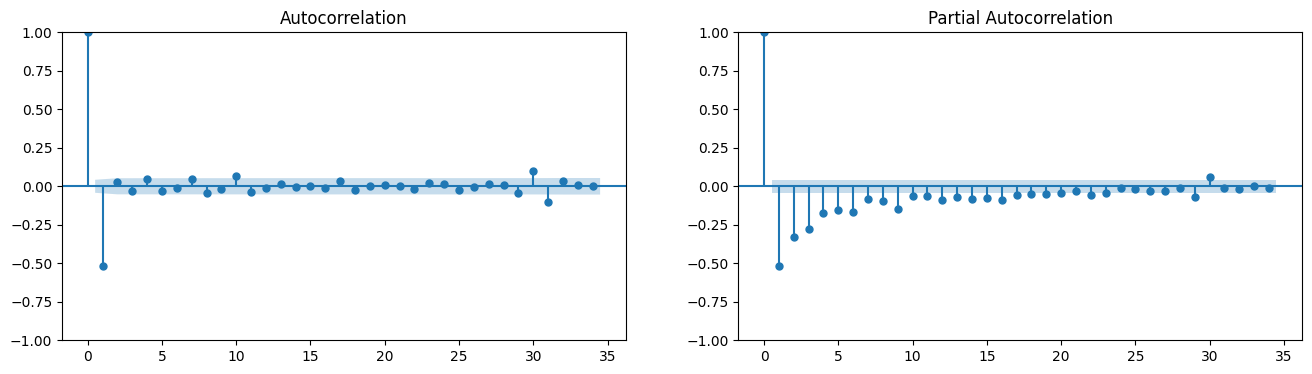

CPU times: user 10.2 s, sys: 290 ms, total: 10.5 s
Wall time: 10.4 s


In [27]:
%%time
print("\n--- Finding Best ARIMA Order ---")
# ARIMA works on the unscaled, 1D time series of the target variable
close_prices = tech_data[cfg.BASELINE_TARGET]
train_size = int(len(close_prices) * (1 - cfg.TEST_SIZE))
train_arima, test_arima = close_prices[0:train_size], close_prices[train_size:]

# Find the best order using our new function
best_arima_order = mdl.find_best_arima_order(train_arima)

# Plot ACF and PACF for visual inspection
# This helps to manually verify the p and q values.
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(train_arima.diff().dropna(), ax=axes[0])
plot_pacf(train_arima.diff().dropna(), ax=axes[1], method="ywm")
plt.show()

In [28]:
%%time
print(f"\n--- Running ARIMA Model with best order {best_arima_order} ---")

history = [x for x in train_arima]
arima_predictions = []

print(f"Performing rolling forecast for {len(test_arima)} steps...")
# The tqdm library provides a progress bar, which is useful here

for t in tqdm(range(len(test_arima))):
    # Use the best order found previously for every forecast
    model_arima = mdl.build_and_train_arima(history, order=best_arima_order)
    output = model_arima.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test_arima[t]
    history.append(obs)

print("ARIMA forecast complete.")


--- Running ARIMA Model with best order (0, 0, 0) ---
Performing rolling forecast for 239 steps...


 54%|█████▍    | 130/239 [00:14<00:13,  8.17it/s]/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|██████████| 239/239 [00:27<00:00,  8.79it/s]

ARIMA forecast complete.
CPU times: user 26.9 s, sys: 287 ms, total: 27.2 s
Wall time: 27.2 s


Plot saved to Output/NVDA_ARIMA_analysis.png


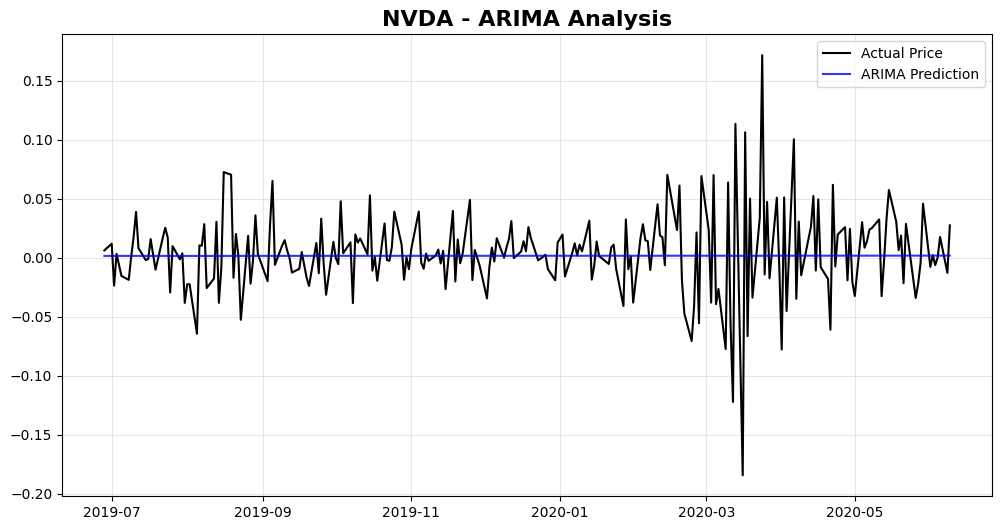

{'Model': 'ARIMA', 'RMSE': np.float64(0.03534137838735806), 'MAE': 0.024276985285806758, 'MAPE (%)': np.float64(64325.80842982063), 'R-squared': -0.004940658539311249, 'Directional_Accuracy': np.float64(24.789915966386555), 'MASE': np.float64(0.9678984604032407)}
CPU times: user 110 ms, sys: 7.45 ms, total: 118 ms
Wall time: 121 ms


In [29]:
%%time
arima_predictions_np = np.array(arima_predictions).reshape(-1, 1)
y_test_arima_np = np.array(test_arima).reshape(-1, 1)
arima_metrics = ut.calculate_metrics(
    y_test_arima_np, arima_predictions_np, "ARIMA", train_arima
)

ut.plot_non_keras_results(
    y_test_arima_np,
    arima_predictions_np,
    test_arima.index,
    cfg.STOCK_SYMBOL,
    "ARIMA",
)

print(arima_metrics)

### 7. Final Performance Comparison

In [30]:
%%time
naive_preds = np.roll(y_test_tech_scaled, 1)
naive_preds[0] = y_test_tech_scaled[0]
naive_metrics = ut.calculate_metrics(y_test_tech_scaled, naive_preds, "Naive Baseline", y_train_tech)

# --- UPDATED TO INCLUDE ALL MODELS ---
all_metrics_df = pd.DataFrame(
    [
        naive_metrics,
        baseline_metrics,
        enhanced_metrics,
        multi_layer_metrics,
        multi_enhanced_metrics,
        baseline_gru_metrics,
        enhanced_gru_metrics,
        baseline_svm_metrics,
        enhanced_svm_metrics,
        arima_metrics,
    ]
).round(4)

print("\n📊 COMPREHENSIVE PERFORMANCE COMPARISON")
print("-" * 60)
print(all_metrics_df.to_string(index=False))
print("-" * 60)

metrics_to_evaluate = {
    "RMSE": "min",
    "MAE": "min",
    "MAPE (%)": "min",
    "MASE": "min",
    "R-squared": "max",
    "Directional_Accuracy": "max"
}

print("\n🏆 Best Model for Each Metric")
print("-" * 60)
for metric, method in metrics_to_evaluate.items():
    if method == "min":
        # For metrics where lower is better (like RMSE, MAE, MAPE, MASE)
        winner_idx = all_metrics_df[metric].idxmin()
    else:
        # For metrics where higher is better (like R-squared, Directional Accuracy)
        winner_idx = all_metrics_df[metric].idxmax()

    winner_row = all_metrics_df.loc[winner_idx]
    print(f"{metric:<22}: {winner_row['Model']} (Score: {winner_row[metric]:.4f})")
print("-" * 60)


📊 COMPREHENSIVE PERFORMANCE COMPARISON
------------------------------------------------------------
                    Model   RMSE    MAE    MAPE (%)  R-squared  Directional_Accuracy   MASE
           Naive Baseline 0.0568 0.0381 687884.6103    -1.6002               29.8319 0.7450
        Single-Layer LSTM 0.0357 0.0241  55697.8332    -0.0257               68.0672 0.4717
            Enhanced LSTM 0.0355 0.0244   7502.3577    -0.0124               26.0504 0.4779
         Multi-Layer LSTM 0.0354 0.0244  20134.0581    -0.0098               75.2101 0.4764
Multi-Layer Enhanced LSTM 0.0355 0.0244  10276.8624    -0.0111               70.5882 0.4768
             Baseline GRU 0.0355 0.0244  66726.0111    -0.0138               42.8571 0.4776
             Enhanced GRU 0.0361 0.0248  81112.0343    -0.0482               44.5378 0.4848
                      SVM 0.0447 0.0316 154363.6930    -0.6066               54.6218 0.6191
             Enhanced SVM 0.0370 0.0267 545088.1622    -0.1015         

In [36]:
%%time
ranking_df = all_metrics_df.copy()

# Lower is better for these metrics
ranking_df["RMSE_Rank"] = ranking_df["RMSE"].rank(method="min", ascending=True)
ranking_df["MAE_Rank"] = ranking_df["MAE"].rank(method="min", ascending=True)
ranking_df["MAPE_Rank"] = ranking_df["MAPE (%)"].rank(method="min", ascending=True)
ranking_df["MASE_Rank"] = ranking_df["MASE"].rank(method="min", ascending=True)

# Higher is better for these metrics
ranking_df["DA_Rank"] = ranking_df["Directional_Accuracy"].rank(method="min", ascending=False)
ranking_df["R2_Rank"] = ranking_df["R-squared"].rank(method="min", ascending=False)

# Create a total rank score (e.g., based on the most important metrics)
ranking_df["Total_Rank"] = (
        ranking_df["MASE_Rank"] + ranking_df["MAPE_Rank"] + ranking_df["DA_Rank"]
)

final_ranking = ranking_df.sort_values(by="Total_Rank", ascending=True)

print("\n🏆 Overall Model Ranking (Lower Total_Rank is Better)")
print("-" * 60)
print(
    final_ranking[["Model", "Total_Rank", "RMSE", "MAE", "MAPE (%)", "R-squared", "MASE", "Directional_Accuracy"]]
    .reset_index(drop=True)
    .to_string()
)


🏆 Overall Model Ranking (Lower Total_Rank is Better)
------------------------------------------------------------
                       Model  Total_Rank    RMSE     MAE     MAPE (%)  R-squared    MASE  Directional_Accuracy
0           Multi-Layer LSTM         6.0  0.0354  0.0244   20134.0581    -0.0098  0.4764               75.2101
1  Multi-Layer Enhanced LSTM         7.0  0.0355  0.0244   10276.8624    -0.0111  0.4768               70.5882
2          Single-Layer LSTM         8.0  0.0357  0.0241   55697.8332    -0.0257  0.4717               68.0672
3              Enhanced LSTM        15.0  0.0355  0.0244    7502.3577    -0.0124  0.4779               26.0504
4               Baseline GRU        17.0  0.0355  0.0244   66726.0111    -0.0138  0.4776               42.8571
5               Enhanced GRU        18.0  0.0361  0.0248   81112.0343    -0.0482  0.4848               44.5378
6                        SVM        20.0  0.0447  0.0316  154363.6930    -0.6066  0.6191               54.62

Plot saved to Output/NVDA_all_models_comparison.png


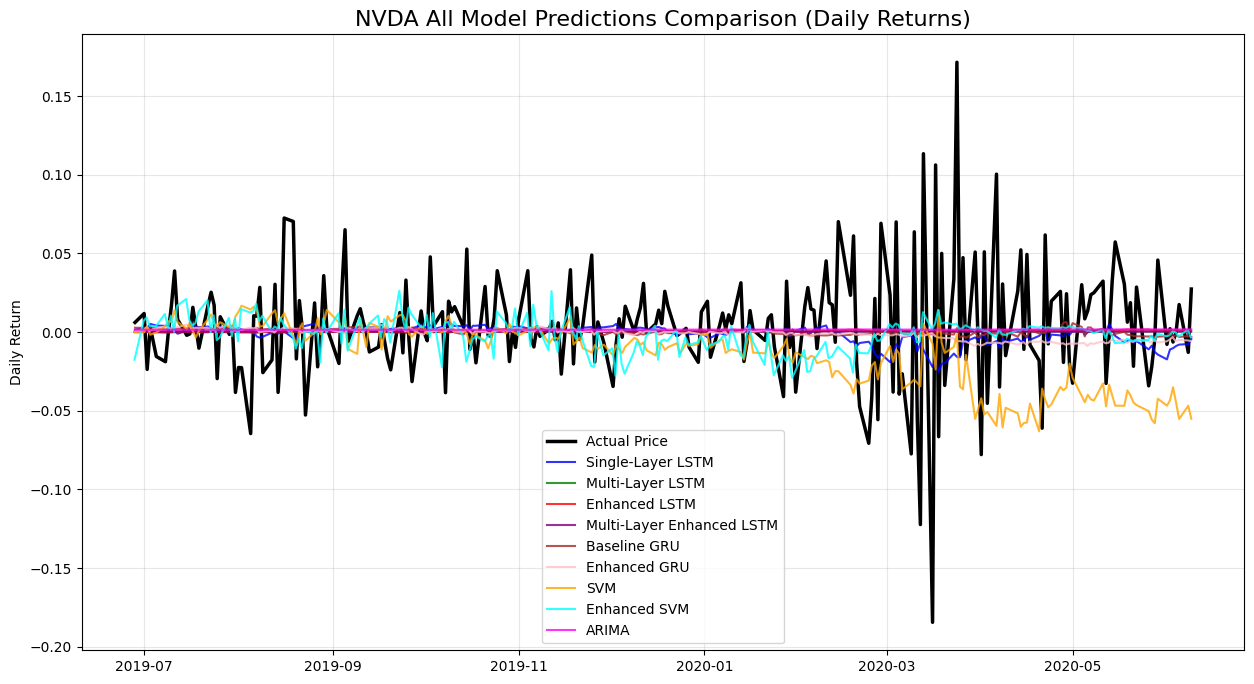

CPU times: user 177 ms, sys: 7.99 ms, total: 185 ms
Wall time: 186 ms


In [32]:
%%time
plot_data = {
    "Actual": {"dates": test_dates_tech, "values": y_test_tech_scaled},
    "Single-Layer LSTM": {"dates": test_dates_tech, "values": base_preds_scaled},
    "Multi-Layer LSTM": {"dates": test_dates_tech, "values": multi_preds_scaled},
    "Enhanced LSTM": {"dates": test_dates_enh, "values": enh_preds_scaled},
    "Multi-Layer Enhanced LSTM": {
        "dates": test_dates_enh,
        "values": multi_enh_preds_scaled,
    },
    "Baseline GRU": {"dates": test_dates_tech, "values": base_gru_preds_scaled},
    "Enhanced GRU": {"dates": test_dates_enh, "values": enh_gru_preds_scaled},
    "SVM": {"dates": test_dates_tech, "values": base_svm_preds_scaled},
    "Enhanced SVM": {"dates": test_dates_enh, "values": enh_svm_preds_scaled},
    "ARIMA": {"dates": test_arima.index, "values": arima_predictions_np},
}

ut.plot_final_comparison(plot_data, cfg.STOCK_SYMBOL, f"{cfg.STOCK_SYMBOL} All Model Predictions Comparison (Daily Returns)")

Plot saved to Output/NVDA_all_models_comparison.png


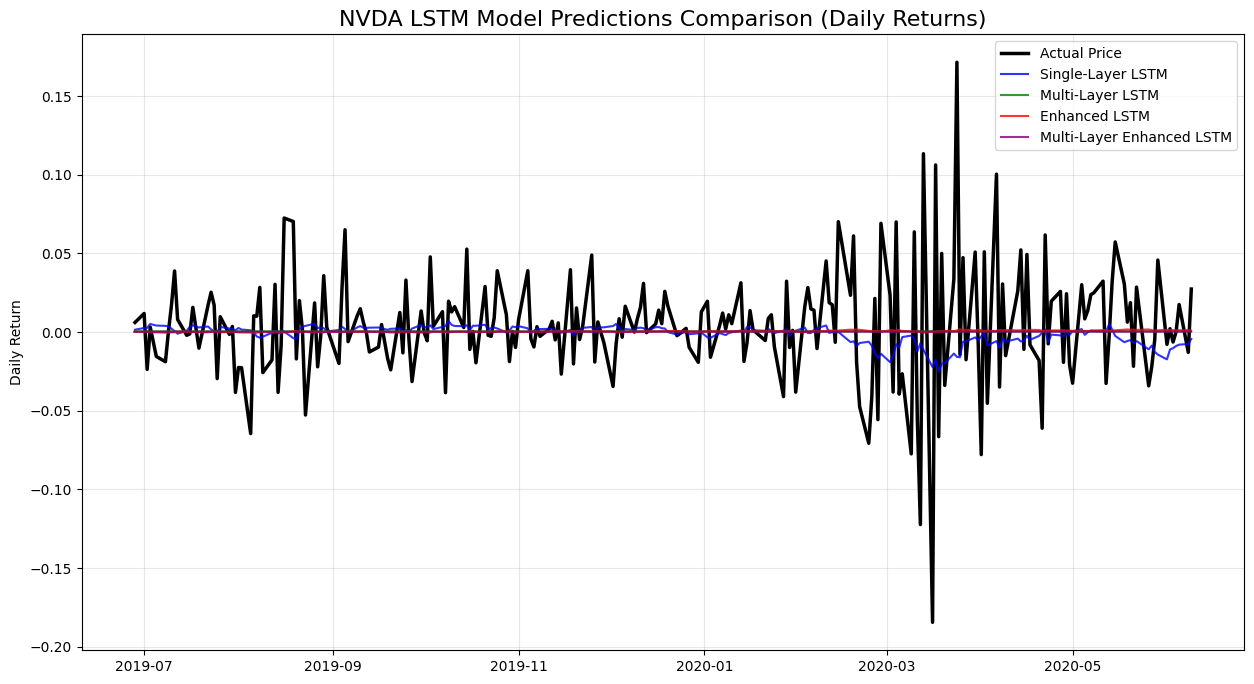

CPU times: user 141 ms, sys: 5.86 ms, total: 147 ms
Wall time: 147 ms


In [33]:
%%time
plot_data = {
    "Actual": {"dates": test_dates_tech, "values": y_test_tech_scaled},
    "Single-Layer LSTM": {"dates": test_dates_tech, "values": base_preds_scaled},
    "Multi-Layer LSTM": {"dates": test_dates_tech, "values": multi_preds_scaled},
    "Enhanced LSTM": {"dates": test_dates_enh, "values": enh_preds_scaled},
    "Multi-Layer Enhanced LSTM": {
        "dates": test_dates_enh,
        "values": multi_enh_preds_scaled,
    },
}

ut.plot_final_comparison(plot_data, cfg.STOCK_SYMBOL, f"{cfg.STOCK_SYMBOL} LSTM Model Predictions Comparison (Daily Returns)")

In [34]:
try:
    end_time = time.time()
    total_time = end_time - start_time
    print(f"--- Total Notebook Runtime: {ut.format_runtime(total_time)} seconds ---")
except NameError:
    print("⚠️ --- Timer could not be stopped because 'start_time' was not defined.")

--- Total Notebook Runtime: 35 minutes 49.93 seconds seconds ---
